In [1]:
import pandas as pd

train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

print("train size", len(train_df))
print("val size", len(val_df))
print("test size", len(test_df))

train size 20000
val size 2000
test size 5000


In [2]:
train_df.sample(10)

,SoundID,label
17858,17858,on a bivariate copula for
5613,5613,electronic multicriticality in bilayer graphene
6071,6071,visualising the arithmetic
6658,6658,complete convergence theorem for stationary
3159,3159,a note on
8197,8197,electrically switchable metadevices via graphene
7038,7038,possible solution to the poincare
17239,17239,efficient relaxations for dense
8925,8925,video corpus moment retrieval
19886,19886,on the observability of


In [3]:
vocab = set()
for x in train_df["label"].to_list():
    for char in x:
        vocab.add(char)

print(sorted([x for x in vocab]))
print(len(vocab))

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27


<AxesSubplot:>

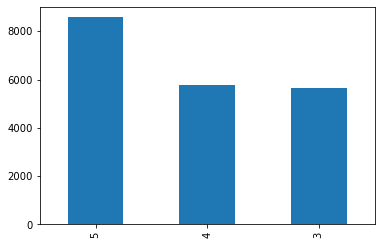

In [4]:
label_lengths = train_df["label"].apply(lambda x: len(x.split()))
label_lengths.value_counts().plot(kind="bar")

<AxesSubplot:>

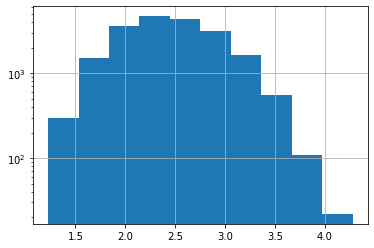

In [5]:
import librosa

audio_durations = train_df["SoundID"].apply(
    lambda x: librosa.core.get_duration(filename=f"data/train/{x}.wav")
)
audio_durations.hist(log=True)

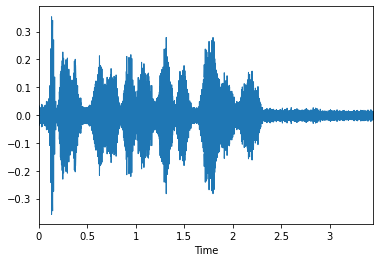

In [6]:
import librosa.display
import matplotlib.pyplot as plt

example_file = f"data/train/{train_df['SoundID'][0]}.wav"
audio, sample_rate = librosa.load(example_file)
librosa.display.waveplot(audio)

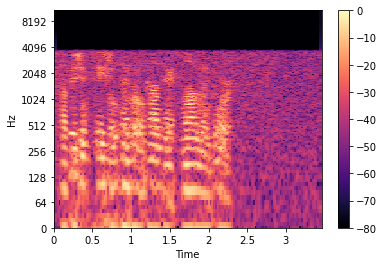

In [7]:
import numpy as np

spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)

librosa.display.specshow(spec_db, y_axis="log", x_axis="time")
plt.colorbar()

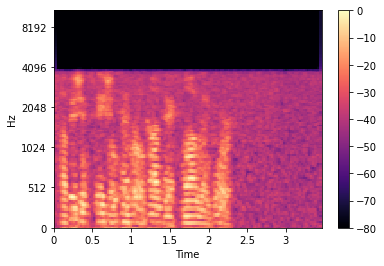

In [8]:
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(mel_spec_db, x_axis="time", y_axis="mel")
plt.colorbar()

In [9]:
import nemo
import nemo.collections.asr as nemo_asr

[NeMo W 2021-06-13 21:22:05 optimizers:47] Apex was not found. Using the lamb optimizer will error out.
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2021-06-13 21:22:06 experimental:27] Module <class 'nemo.collections.asr.data.audio_to_text_dali.AudioToCharDALIDataset'> is experimental, not ready for production and is not fully supported. Use at your own risk.


In [10]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2021-06-13 21:22:07 cloud:56] Found existing object /home/students/acct3001_02/.cache/torch/NeMo/NeMo_1.0.2/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.
[NeMo I 2021-06-13 21:22:07 cloud:62] Re-using file from: /home/students/acct3001_02/.cache/torch/NeMo/NeMo_1.0.2/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo
[NeMo I 2021-06-13 21:22:07 common:676] Instantiating model from pre-trained checkpoint
[NeMo I 2021-06-13 21:22:08 features:252] PADDING: 16
[NeMo I 2021-06-13 21:22:08 features:269] STFT using torch
[NeMo I 2021-06-13 21:22:09 modelPT:439] Model EncDecCTCModel was successfully restored from /home/students/acct3001_02/.cache/torch/NeMo/NeMo_1.0.2/QuartzNet15x5Base-En/2b066be39e9294d7100fb176ec817722/QuartzNet15x5Base-En.nemo.


In [11]:
files = [example_file]
transcription = quartznet.transcribe(paths2audio_files=files)[0]

print(f"Audio in {example_file} was recognized as: {transcription}")

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

[NeMo W 2021-06-13 21:22:10 patch_utils:49] torch.stft() signature has been updated for PyTorch 1.7+
    Please update PyTorch to remain compatible with later versions of NeMo.
Audio in data/train/0.wav was recognized as: vsstationa eo war


In [12]:
quartznet.decoder.vocabulary

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]

In [13]:
import os
import json

def build_manifest(df, data_path, manifest_file):
    with open(manifest_file, "w", encoding="utf-8") as f:
        for _, x in df.iterrows():
            audio_path = os.path.join(data_path, f'{x["SoundID"]}.wav')
            duration = librosa.core.get_duration(filename=audio_path)
            
            item = {
                "audio_filepath": audio_path,
                "duration": duration,
                "text": x["label"]
            }
            
            json.dump(item, f)
            f.write("\n")
    
build_manifest(train_df, "data/train", "train_manifest.json")
build_manifest(val_df, "data/val", "val_manifest.json")
build_manifest(test_df, "data/test", "test_manifest.json")

In [14]:
from ruamel.yaml import YAML

config_path = "config.yaml"
yaml = YAML(typ="safe")

with open(config_path) as f:
    params = yaml.load(f)
    
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 512, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'tarred_shard_strategy': 'scatter'}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 512, 'shuffle': False}, 'preprocessor': {'_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'norm

In [15]:
from omegaconf import DictConfig

params["model"]["train_ds"]["manifest_filepath"] = "train_manifest.json"
params["model"]["train_ds"]["batch_size"] = 128
params["model"]["train_ds"]["max_duration"] = 5
params["model"]["train_ds"]["num_workers"] = 4
params["model"]["train_ds"]["pin_memory"] = True

params["model"]["validation_ds"]["manifest_filepath"] = "val_manifest.json"
params["model"]["validation_ds"]["batch_size"] = 128
params["model"]["validation_ds"]["num_workers"] = 4
params["model"]["validation_ds"]["pin_memory"] = True

params["model"]["optim"]["lr"] = 1e-4

In [16]:
quartznet.setup_optimization(optim_config=DictConfig(params["model"]["optim"]))
quartznet.setup_training_data(train_data_config=params["model"]["train_ds"])
quartznet.setup_validation_data(val_data_config=params["model"]["validation_ds"])

[NeMo W 2021-06-13 21:22:24 modelPT:643] Trainer wasn't specified in model constructor. Make sure that you really wanted it.
[NeMo I 2021-06-13 21:22:24 modelPT:751] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )
[NeMo W 2021-06-13 21:22:24 lr_scheduler:604] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !
[NeMo I 2021-06-13 21:22:24 audio_to_text_dataset:36] Model level config does not container `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2021-06-13 21:22:24 audio_to_text_dataset:36] Model level config does not container `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2021-06-13 21:22:25 collections:173] Dataset loaded with 20000 files totalling 13.69 hours
[NeMo I 

In [24]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

trainer = pl.Trainer(
    resume_from_checkpoint="lightning_logs/version_1/checkpoints/epoch=19-step=3139.ckpt",
    gpus=1, 
    max_epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss"),
        ModelCheckpoint(monitor="val_loss")
    ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [23]:
trainer.fit(quartznet)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
[NeMo W 2021-06-13 22:07:29 modelPT:643] Trainer wasn't specified in model constructor. Make sure that you really wanted it.
[NeMo I 2021-06-13 22:07:29 modelPT:751] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.0001
        weight_decay: 0.001
    )
[NeMo W 2021-06-13 22:07:29 lr_scheduler:604] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18.9 M
2 | decoder           | ConvASRDecoder                    | 29.7 K
3 | loss              | CTCLoss          

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
test_audio_files = [os.path.join("data", "test", f"{x}.wav") for x in test_df["SoundID"]]

results = first_asr_model.transcribe(path2audio_files=test_audio_files, batch_size=64)